In [106]:
# Model Steps:

# 1-Training Data
# 2-Preprocessing
# 3-Arch.
# 4-Fine Tune, Pre-trained mode
# 5-Optimize Hyperparameters
# 6-Evalutaion
# 7-Deploy

In [164]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras import applications
import tensorflow as tf

In [158]:
train='D:/Final/Graduation project/datasets/casting_data/casting_data/train'
test='D:/Final/Graduation project/datasets/casting_data/casting_data/test'

class_names = ['def_front', 'ok_front']
folder_names = ['def_aug', 'ok_aug']
class_to_folder = dict(zip(range(len(class_names)), folder_names))
batch_size = 32
img_size = (224, 224)

In [ ]:

# to produce a batches enough for trainning req 

#it will generate 30* 32 image
num_images_to_generate = 30
for i in range(num_images_to_generate):
    batch = traindata.next()
    for j in range(batch_size):
        img = batch[0][j]
        label = batch[1][j]
        class_index = tf.argmax(label).numpy()
        folder_path = os.path.join(train, 'defected' if label[0] == 1 else 'good')
        save_path = os.path.join(folder_path, f'{class_to_folder[class_index]}_{i}.jpg')
        tf.keras.preprocessing.image.save_img(save_path, img)

for i in range(num_images_to_generate):
    batch = testdata.next()
    for j in range(batch_size):
        img = batch[0][j]
        label = batch[1][j]
        class_index = tf.argmax(label).numpy()
        folder_path = os.path.join(test, 'predict')
        save_path = os.path.join(folder_path, f'{class_to_folder[class_index]}_{i}.jpg')
        tf.keras.preprocessing.image.save_img(save_path, img)



In [168]:
trdata = ImageDataGenerator(
    	rescale = 1 / 255.0,
        validation_split = 0.20)

traindata = trdata.flow_from_directory(directory=train ,batch_size=32 ,
                                       target_size=(224,224), subset='training',
                                       shuffle=True,color_mode='rgb',class_mode='categorical')

valid_generator = trdata.flow_from_directory(
    directory=train,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32 ,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
)

tsdata = ImageDataGenerator(rescale= 1/255.0)
testdata = tsdata.flow_from_directory(directory=test, target_size=(224,224),color_mode='rgb',
                                      batch_size=1,class_mode=None,shuffle=False)



#validation_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
#valid_generator = valid_generator.batch(3).repeat()



Found 6278 images belonging to 2 classes.
Found 1569 images belonging to 2 classes.
Found 240 images belonging to 1 classes.


In [169]:
VGG = keras.applications.vgg16.VGG16(input_shape=(224,224,3), include_top = False, weights='imagenet')

In [170]:
VGG.trainable = False
#Not train the front 13 layers, train only last two layers

In [171]:
model = keras.Sequential([
    VGG,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dense(units=2, activation="softmax"), 
])

In [172]:
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [173]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 25088)             0         
                                                                 
 dense_24 (Dense)            (None, 256)               6422784   
                                                                 
 dense_25 (Dense)            (None, 256)               65792     
                                                                 
 dense_26 (Dense)            (None, 2)                 514       
                                                                 
Total params: 21,203,778
Trainable params: 6,489,090
Non-trainable params: 14,714,688
_________________________________________________________________


In [174]:
hist = model.fit(traindata , steps_per_epoch = 196   , epochs = 5 , #traindata.n 
                           validation_data = valid_generator, validation_steps = 49)
model.save('vggclf_v5.h5')


# Your input ran out of data; interrupting training. Make sure that your 
#dataset or generator can generate at least `steps_per_epoch * epochs` batches 
# image data generator should generate at least 195*10 = 1950 so if i set batch size to 32 so i need a 
# 6230 / 32 = 195 batch to go through entire data set  

Epoch 1/5
196/196 [==============================] - 1864s 10s/step - loss: 0.2971 - accuracy: 0.8935 - val_loss: 0.0567 - val_accuracy: 0.9866
Epoch 2/5
196/196 [==============================] - 1835s 9s/step - loss: 0.0590 - accuracy: 0.9808 - val_loss: 0.0260 - val_accuracy: 0.9949
Epoch 3/5
196/196 [==============================] - 1773s 9s/step - loss: 0.0539 - accuracy: 0.9829 - val_loss: 0.0781 - val_accuracy: 0.9751
Epoch 4/5
196/196 [==============================] - 1814s 9s/step - loss: 0.0310 - accuracy: 0.9914 - val_loss: 0.0202 - val_accuracy: 0.9955
Epoch 5/5
196/196 [==============================] - 1798s 9s/step - loss: 0.0311 - accuracy: 0.9904 - val_loss: 0.0229 - val_accuracy: 0.9949


In [175]:
model.evaluate(valid_generator)

50/50 [==============================] - 337s 7s/step - loss: 0.0229 - accuracy: 0.9949


[0.022895874455571175, 0.9949012398719788]

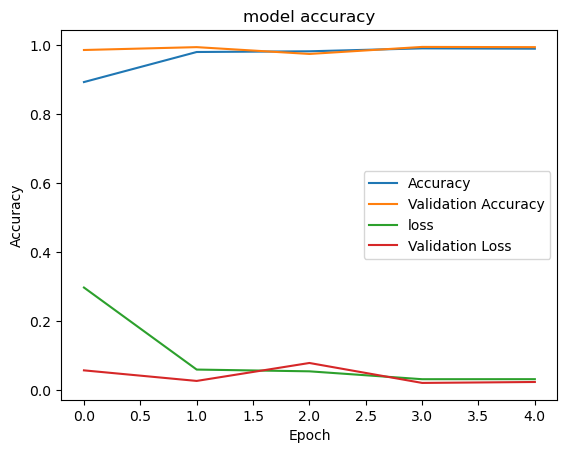

In [176]:

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()


In [177]:
pred = model.predict(testdata,steps = testdata.n, verbose = 1)

pred

240/240 [==============================] - 68s 284ms/step


array([[1.00000000e+00, 1.36552614e-09],
       [9.99999762e-01, 2.33469962e-07],
       [9.97740984e-01, 2.25897436e-03],
       [9.99426484e-01, 5.73581667e-04],
       [1.00000000e+00, 3.48298335e-10],
       [1.00000000e+00, 1.04021947e-09],
       [9.00072753e-01, 9.99271870e-02],
       [9.99977827e-01, 2.21525661e-05],
       [9.99751151e-01, 2.48902914e-04],
       [1.00000000e+00, 5.99224137e-09],
       [9.99995828e-01, 4.21133154e-06],
       [1.08102575e-01, 8.91897380e-01],
       [9.99998927e-01, 1.04699075e-06],
       [1.00000000e+00, 8.63174879e-11],
       [9.99999642e-01, 3.24852664e-07],
       [9.99944925e-01, 5.51031990e-05],
       [9.99472797e-01, 5.27213502e-04],
       [1.00000000e+00, 1.91895140e-08],
       [9.99940515e-01, 5.94614139e-05],
       [9.99928474e-01, 7.15617716e-05],
       [9.99988556e-01, 1.14417071e-05],
       [1.00000000e+00, 2.64626810e-11],
       [1.00000000e+00, 5.58492705e-12],
       [9.99994397e-01, 5.54805047e-06],
       [9.999766

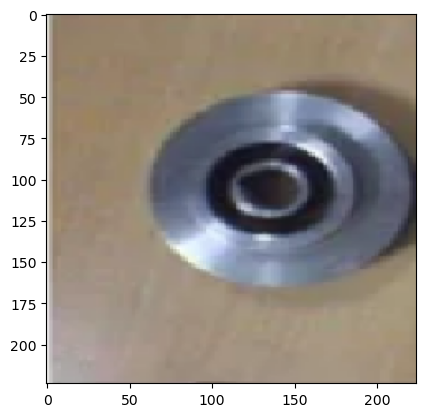

In [178]:
from keras.preprocessing import image
img = keras.utils.load_img("D:/Final/Graduation project/datasets/12.png",target_size=(224,224))
img = np.asarray(img)


plt.imshow(img)
img = np.expand_dims(img, axis=0)

In [179]:
from keras.models import load_model
saved_model = load_model("vggclf_v5.h5")


1/1 [==============================] - 1s 620ms/step
good
[[0. 1.]]


In [181]:
output = model.predict(img)
if output[0][0] > output[0][1]:
    print("defected")
    print(output)
else:
    print("good")
    print(output)

1/1 [==============================] - 0s 268ms/step
good
[[0. 1.]]


In [182]:
import pickle
  
# Save the trained model as a pickle string.
saved_model = pickle.dumps(model)
model_from_pickle = pickle.loads(saved_model)


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\flatten
......vars
...layers\functional
......vars
...layers\functional\layers\conv2d
......vars
.........0
.........1
...layers\functional\layers\conv2d_1
......vars
.........0
.........1
...layers\functional\layers\conv2d_10
......vars
.........0
.........1
...layers\functional\layers\conv2d_11
......vars
.........0
.........1
...layers\functional\layers\conv2d_12
......vars
.........0
.........1
...layers\functional\layers\conv2d_2
......vars
.........0
.........1
...layers\functional\layers\conv2d_3
......vars
.........0
.........1
...layers\functional\layers\conv2d_4
......vars
.........0
.........1
...layers\functional\layers\conv2d_5
......vars
.........0
.........1
...layers\functional\layers\conv2d_6
......vars
.........0
.........1
...layers\functional\